<a href="https://colab.research.google.com/github/AIDA-DA/aida-project-image-scene/blob/main/notebooks/Project_Image_Scene_Classification_ResNet50_Places_365.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Places 365 Pretrained Model Conversion

Download the official pretrained models from [CSAILVision/places365](https://github.com/CSAILVision/places365) and convert them into Keras H5. The purpose of this conversion is to use those pretrained models later as initial weights for our Transfer Learning. Luckely for us the MIT CSAIL Computer Vision Group provides already a [script](https://github.com/CSAILVision/places365/blob/master/run_placesCNN_basic.py
) on how to load their PyTorch model.

In [59]:
# PlacesCNN for scene classification
#
# by Bolei Zhou
# last modified by Bolei Zhou, Dec.27, 2017 with latest pytorch and torchvision 
# (upgrade your torchvision please if there is trn.Resize error)

import torch
from torch.autograd import Variable as V
import torchvision.models as models
from torchvision import transforms as trn
from torch.nn import functional as F
import os
from PIL import Image
import urllib.request
import numpy as np
import tensorflow as tf

In [60]:
# th architecture to use
arch = 'resnet50'

# load the pre-trained weights
model_file = f'{arch}_places365.pth.tar'
if not os.path.exists(model_file):
    weight_url = 'http://places2.csail.mit.edu/models_places365/' + model_file
    urllib.request.urlretrieve(weight_url, model_file)

model = models.__dict__[arch](num_classes=365)
checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
model.load_state_dict(state_dict)
model.eval()


# load the image transformer
centre_crop = trn.Compose([
        trn.Resize((256,256)),
        trn.CenterCrop(224),
        trn.ToTensor(),
        trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# load the class label
file_name = 'categories_places365.txt'
if not os.path.exists(file_name):
    synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/categories_places365.txt'
    urllib.request.urlretrieve(synset_url, file_name)
classes = list()
with open(file_name) as class_file:
    for line in class_file:
        classes.append(line.strip().split(' ')[0][3:])
classes = tuple(classes)

Let's load the test image and predict the results. We will check on the rsults again once we converted the model to TF-Keras.

In [61]:
img_name = '12.jpg'
if not os.path.exists(img_name):
    img_url = 'http://places.csail.mit.edu/demo/' + img_name
    urllib.request.urlretrieve(img_url, img_name)

img = Image.open(img_name)
input_img = V(centre_crop(img).unsqueeze(0))

# forward pass
logit = model.forward(input_img)
h_x = F.softmax(logit, 1).data.squeeze()
probs, idx = h_x.sort(0, True)

print('{} prediction on {}'.format(arch,img_name))
# output the prediction
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

resnet50 prediction on 12.jpg
0.685 -> patio
0.240 -> restaurant_patio
0.019 -> beer_garden
0.010 -> courtyard
0.010 -> porch


Now we install the PyTorch to Keras model convertor `pytorch2keras` written by Grigory Malivenko to convert the model. His script uses the possibility to [export PyTorch models](https://pytorch.org/docs/stable/onnx.html) into [ONNX](https://onnx.ai/get-started.html) and then applies his `onnx2keras` package.

In [62]:
pip install pytorch2keras 

In [63]:
from pytorch2keras import pytorch_to_keras

The next step is to create a dummy variable from the sample image created above.

In [64]:
input_var = V(torch.FloatTensor(input_img))

In [65]:
[tuple(input_img.data.shape)[1:]]

[(3, 224, 224)]

In [66]:
k_model = pytorch_to_keras(model, input_var, [(3, None, None,)], verbose=False)  

INFO:pytorch2keras:Converter is called.
DEBUG:pytorch2keras:Input_names:
DEBUG:pytorch2keras:['input_0']
DEBUG:pytorch2keras:Output_names:
DEBUG:pytorch2keras:['output_0']
INFO:onnx2keras:Converter is called.
DEBUG:onnx2keras:List input shapes:
DEBUG:onnx2keras:[(3, None, None)]
DEBUG:onnx2keras:List inputs:
DEBUG:onnx2keras:Input 0 -> input_0.
DEBUG:onnx2keras:List outputs:
DEBUG:onnx2keras:Output 0 -> output_0.
DEBUG:onnx2keras:Gathering weights to dictionary.
DEBUG:onnx2keras:Found weight 497 with shape (64, 3, 7, 7).
DEBUG:onnx2keras:Found weight 498 with shape (64,).
DEBUG:onnx2keras:Found weight 500 with shape (64, 64, 1, 1).
DEBUG:onnx2keras:Found weight 501 with shape (64,).
DEBUG:onnx2keras:Found weight 503 with shape (64, 64, 3, 3).
DEBUG:onnx2keras:Found weight 504 with shape (64,).
DEBUG:onnx2keras:Found weight 506 with shape (256, 64, 1, 1).
DEBUG:onnx2keras:Found weight 507 with shape (256,).
DEBUG:onnx2keras:Found weight 509 with shape (256, 64, 1, 1).
DEBUG:onnx2keras:F

In [67]:
k_model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_0 (InputLayer)            [(None, 3, None, Non 0                                            
__________________________________________________________________________________________________
496_pad (ZeroPadding2D)         (None, 3, None, None 0           input_0[0][0]                    
__________________________________________________________________________________________________
496 (Conv2D)                    (None, 64, None, Non 9472        496_pad[0][0]                    
__________________________________________________________________________________________________
323 (Activation)                (None, 64, None, Non 0           496[0][0]                        
_______________________________________________________________________________________

In [68]:
k_model.save('/content/resnet50_places365.h5')

Let's try the same picture again with the Keras model

In [69]:
np.array(input_img).shape

(1, 3, 224, 224)

In [70]:
k_logit = k_model.predict(np.array(input_img))
h_x_k = tf.squeeze(tf.keras.layers.Softmax()(k_logit)).numpy()
idx = h_x_k.argsort()[::-1]
probs = np.sort(h_x_k)[::-1]

print('{} prediction on {}'.format(arch,img_name))
# output the prediction
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

resnet50 prediction on 12.jpg
0.685 -> patio
0.240 -> restaurant_patio
0.019 -> beer_garden
0.010 -> courtyard
0.010 -> porch


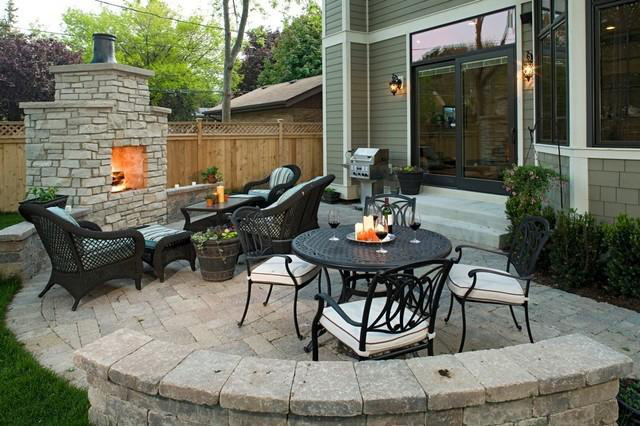

In [71]:
img

That looks pretty good!